In [353]:
import pandas as pd
import matplotlib.pyplot as plt
import jieba
import re
import warnings
from pyecharts import Style, Geo, Map, Line, Pie
from chinese_province_city_area_mapper.transformer import CPCATransformer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from snownlp import SnowNLP

warnings.filterwarnings('ignore')

% matplotlib inline

### <font color=blue>1、读取并简单处理数据</font>

In [287]:
# 读取数据
df1 = pd.read_csv('comments.csv', names=['name', 'score', 'comment', 'date', 'href'])
df2 = pd.read_csv('cities.csv', names=['city'])
df = pd.merge(df1, df2, left_index=True, right_index=True, how='outer') # 根据索引合并数据

In [288]:
df.info() # 看一下是否有缺失数据

<class 'pandas.core.frame.DataFrame'>
Int64Index: 480 entries, 0 to 479
Data columns (total 6 columns):
name       480 non-null object
score      480 non-null object
comment    480 non-null object
date       480 non-null object
href       480 non-null object
city       480 non-null object
dtypes: object(6)
memory usage: 46.2+ KB


In [289]:
df.drop('href', axis=1, inplace=True) # 去掉href列
df.drop_duplicates(subset=None, keep='first', inplace=True) # 去重（这里没有重复值）
df.dropna(axis=0) # 删除空值 (这里没有空值)

# 去掉comment的span标签
def comment_process(comment):
    comment = comment.strip('<span class="short">').strip('</span>').replace('\n', '').replace('\r', '')
    p = re.compile('[^\u4e00-\u9fa5]')  # 中文编码范围\u4e00到\u9fa5
    comment = re.sub(p,'',comment)
    return comment

df['comment'] = df['comment'].apply(comment_process) # 使用apply比循环要快

# 评分转换数字
df['score1'] = df['score']
df['score'] = df['score'].map({
    '力荐': 5,
    '推荐': 4,
    '还行': 3,
    '较差': 2,
    '很差': 1
})
df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')  # 将datetime字段由object转换成datetime类型，速度回快很多
# 看一下处理结果
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 480 entries, 0 to 479
Data columns (total 6 columns):
name       480 non-null object
score      465 non-null float64
comment    480 non-null object
date       480 non-null object
city       480 non-null object
score1     480 non-null object
dtypes: float64(1), object(5)
memory usage: 26.2+ KB
None


,name,score,comment,date,city,score1
0,姨妈的鸭,5.0,春节期间最大的一场烟花是看你爸为你和地球点燃的宇宙爆炸太朋克了,2019-02-05,上海,力荐
1,Ou,2.0,不论从任何一种标准科幻片的华语片的华语科幻片的来看都不能称得上是部合格影片严重过度剪辑这种典...,2019-02-05,辽宁大连,较差
2,Booige Boom,5.0,热评第一条我就呵呵了中国科幻电影为什么不值得我们打高分去鼓励非要放在国际水平线上才是客观的吗...,2019-02-06,Antigua and Barbuda,力荐
3,[已注销],1.0,一分画面分在一个烧石头都能做热核聚变的高科技时代会搞不清楚发动机的工作条件导致集体熄火拉全人...,2019-02-05,广东广州,很差
4,苏妄言,1.0,这回还真不是吴京的锅而是整个团队的锅前半段尴尬后半段强行撩导演这剪辑和节奏掌握的都赶上各种笔...,2019-02-05,北京,很差


### <font color=blue>2、评论用户地理位置</font>

In [290]:
# 处理城市数据，如'讷河, 齐齐哈尔'提取为齐齐哈尔，'江苏南京'提取为南京，同时去除国外城市
def city_process(line):
    city = re.compile('[^\u4e00-\u9fa5]') # 中文编码范围\u4e00到\u9fa5
    # 取出中文字符，返回列表
    zh = re.split(city, line)
    # 取列表中最后一个，例如'讷河, 齐齐哈尔'取齐齐哈尔
    zh = zh[-1]
    return zh

df['city'] = df['city'].apply(city_process)
# 提取出city中的市
cpca = CPCATransformer()
df['city'] = cpca.transform(df.city)['市']

In [291]:
df1 = df[df['city'] != ''] # 去除城市为空数据

counts = pd.value_counts(df1['city'])
attr = counts.index.to_list()
value = counts[counts.index].to_list()

# 设置地图样式
style = Style(
    title_color="#fff",
    title_pos="center",
    width=1200,
    height=600,
    background_color='#404a59'
)

chart = Geo('<流浪地球>评论用户地理位置', '数据来源：豆瓣', **style.init_style)
# 属性，值
chart.add('', attr, value, # visual_range=[0, 200],
          visual_text_color="#fff", is_legend_show=False,
          symbol_size=15, is_visualmap=True,
          tooltip_formatter='{b}',
          label_emphasis_textsize=15,
          label_emphasis_pos='right')
# chart.render('邪不压正粉丝人群地理位置.html') 保存文件
chart # 直接展示

可以看到，北京上海及沿海城市的评论用户较多

### <font color=blue>3、评分趋势</font>

In [292]:
df2 = df[df['score'] != '--'][['date', 'score', 'score1']] # 去除未评分数据并取出date，score，score1三列
# 提取出5个评分的时间序列
df_5 = df2[df2['score'] == 5][['date', 'score1']]
df_4 = df2[df2['score'] == 4][['date', 'score1']]
df_3 = df2[df2['score'] == 3][['date', 'score1']]
df_2 = df2[df2['score'] == 2][['date', 'score1']]
df_1 = df2[df2['score'] == 1][['date', 'score1']]

# 统计每日评分次数
df_5 = df_5.groupby(['date']).count()
df_4 = df_4.groupby(['date']).count()
df_3 = df_3.groupby(['date']).count()
df_2 = df_2.groupby(['date']).count()
df_1 = df_1.groupby(['date']).count()

line = Line('评分趋势')
line.add('力荐', df_5.index.tolist(), df_5.score1.tolist())
line.add('推荐', df_4.index.tolist(), df_4.score1.tolist())
line.add('还行', df_3.index.tolist(), df_3.score1.tolist())
line.add('较差', df_2.index.tolist(), df_2.score1.tolist())
line.add('很差', df_1.index.tolist(), df_1.score1.tolist())

line

因为爬取的是热门评论，所以是越早的评论点赞越高，如果要分析评分趋势还是需要所有的评论

### <font color=blue>4、各评分占比</font>

In [293]:
score_counts = df[df['score1'] != '--']['score1'].value_counts()
attr = score_counts.index.tolist()
value = score_counts[attr].tolist()

pie = Pie('各评分占比')
pie.add('', attr, value, radius=[30, 75], rosetype='radius', is_legend_show=False, is_label_show=True)
pie

评论以3分4分为主，也有不少5分，总体来说评价还不错

### <font color=blue>5、词云图</font>

In [309]:
comment_cut = ''
comments = df['comment'].tolist()

for comment in comments:
    comment = jieba.cut(comment)
    comment = ' '.join(comment)
    comment_cut += comment

In [348]:
# 添加停用词
stopwords = STOPWORDS.copy()
stopwords.update([
    '流浪', '地球', '这种', '完全', '最后', '但是', '这个', '还是',
    '有点', '电影', '希望', '没有', '就是', '什么', '觉得', '其实',
    '不是', '真的', '感觉', '因为', '这么', '很多', '已经', '一个',
    '这样', '一部', '非常', '那么', '作为', '个人', '基本', '只能',
    '真是', '应该', '不能', '尤其', '可能', '确实', '只是', '一点' 
]) # 还有很多词可以停用，没有全部列出

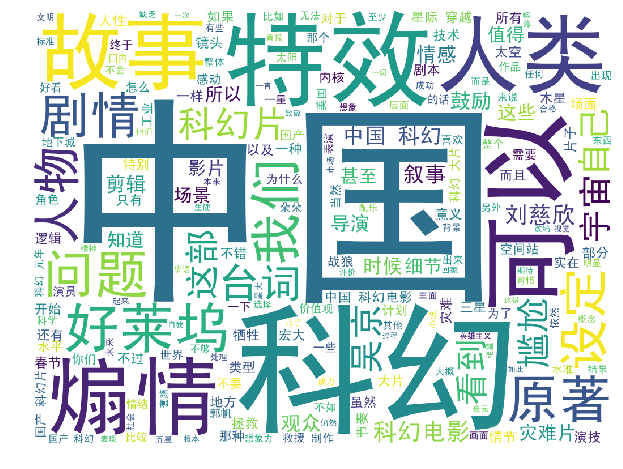

In [349]:
#参数分别是指定字体、背景颜色、最大的词的大小、使用给定图作为背景形状 
wc = WordCloud(width=1024,height=768,background_color='white',
  font_path='Users/wangyutian/Library/Fonts/simhei.ttf',
  stopwords=stopwords,max_font_size=400,
  random_state=50)
wc.generate_from_text(comment_cut)
plt.figure(figsize=(16, 8))
plt.imshow(wc)
plt.axis('off')#不显示坐标轴  
plt.show()
#保存结果到本地
# wc.to_file('wordcloud')

词云图来看，评论用户对本部国产科幻电影的评价还是不错，总体来说还是支持的。我也看了这部电影，特效不错，但是剧情有些低估观众智商而且后面的演讲看的我相当尴尬(⊙﹏⊙)b，总体来说还是不错的，作为国产科幻电影还是值得鼓励的。